## demo decam

This walkthrough uses the Burke et al. 2019 dataset, but superceeds the old Matterport Mask R-CNN implementation.

#### A few notes:

The data can be obtained following the links in the [old repository](https://github.com/burke86/astro_rcnn). The dataset directories should be re-named "test", "train", and "val".

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader

from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

import imgaug.augmenters as iaa

from astrodet import astrodet as toolkit
from astrodet import detectron as detectron_addons

from PIL import Image, ImageEnhance
from astropy.visualization import make_lupton_rgb

from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader, get_detection_dataset_dicts

from detectron2.structures import BoxMode
from astropy.io import fits
import glob

In [2]:
# Print some versions so we know what works
print(torch.__version__)
print(detectron2.__version__)

1.10.1
0.6


In [3]:
import detectron2

detectron2.__path__

['/home/g4merz/.local/lib/python3.9/site-packages/detectron2']

In [4]:
# Prettify the plotting
from astrodet.astrodet import set_mpl_style
set_mpl_style()

In [5]:
#Todo: change the dirpath here
dirpath = '/home/shared/hsc/decam/decam_data/' # Path to dataset
output_dir = '/home/shared/hsc/decam/models/'

dataset_names = ['train', 'test', 'val'] 

### Register Astro R-CNN dataset

#### After saving the datasets as json files, it is much faster to load and prepare in memory

In [6]:

#code snippet for unregistering if you want to change something

if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    MetadataCatalog.remove("astro_train")
    
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    MetadataCatalog.remove("astro_test")
    
if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")
    MetadataCatalog.remove("astro_val")



In [7]:
def get_data_from_json(file):
    # Opening JSON file
    with open(file, 'r') as f:
        data = json.load(f)
    return data


trainfile=os.path.join(dirpath,'train.json')
testfile=os.path.join(dirpath,'test.json')
valfile=os.path.join(dirpath,'val.json')

DatasetCatalog.register("astro_train", lambda: get_data_from_json(trainfile))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy"])
#astrotrain_metadata = MetadataCatalog.get("astro_train") # astro_test dataset needs to exist

DatasetCatalog.register("astro_test", lambda: get_data_from_json(testfile))
MetadataCatalog.get("astro_test").set(thing_classes=["star", "galaxy"])
#astrotest_metadata = MetadataCatalog.get("astro_test") # astro_test dataset needs to exist


DatasetCatalog.register("astro_val", lambda: get_data_from_json(valfile))
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy"])
#astroval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist

namespace(name='astro_val', thing_classes=['star', 'galaxy'])

In [8]:
dataset_dicts = {}
#for i, d in enumerate(dataset_names):
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    filenames_dir = os.path.join(dirpath,d)
    dataset_dicts[d] = get_data_from_json(filenames_dir+'.json')

Loading train
Loading test
Loading val


### Custom image reader

In [9]:
def read_image(filename, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8, A=1e4):
    # Read image
    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton' or normalize.lower() == 'luptonhc':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        
    elif normalize.lower() == 'zscore':
        
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
        
        #zsigma = np.nanstd(z)
        #rsigma = np.nanstd(r)
        #gsigma = np.nanstd(g)
        
        #z = A*(z - np.nanmean(z) - m)/zsigma
        #r = A*(r - np.nanmean(r) - m)/rsigma
        #g = A*(g - np.nanmean(g) - m)/gsigma
        
        
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
        
    
    
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile)
    #max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 RGB image
    image[:,:,0] = z # R
    image[:,:,1] = r # G
    image[:,:,2] = g # B
    
    if normalize.lower() == 'luptonhc':
        factor = 2 #gives original image
        cenhancer = ImageEnhance.Contrast(Image.fromarray(image))
        im_output = cenhancer.enhance(factor)
        benhancer = ImageEnhance.Brightness(im_output)
        image = benhancer.enhance(factor)
    
    return np.asarray(image)

In [10]:
def return_image(filename):

    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    length, width = g.shape
    image = np.zeros([length, width, 3])
    
    # Options for contrast scaling
    
    # 0-255 RGB image
    image[:,:,0] = z # red
    image[:,:,1] = r # green
    image[:,:,2] = g # blue

    return image

### Visualize ground truth examples

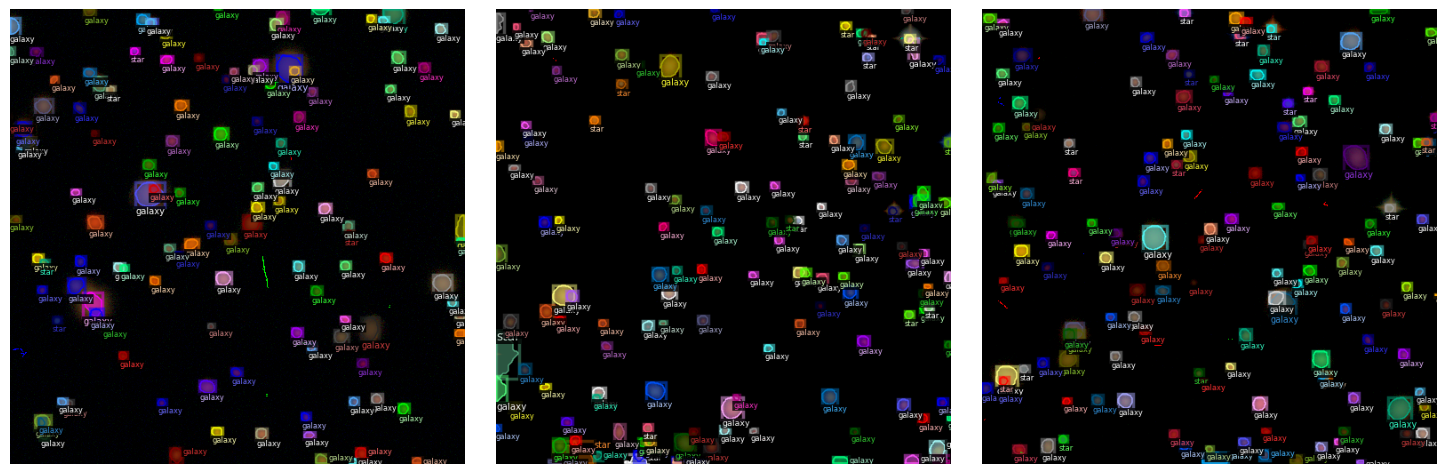

In [11]:
nsample = 3 # Number of example images to plot
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    # Use the Lupton scaling for better visualization
    img = read_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.uint8)

    visualizer = Visualizer(img, metadata=MetadataCatalog.get("astro_test"))
    # Plot the figures
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()


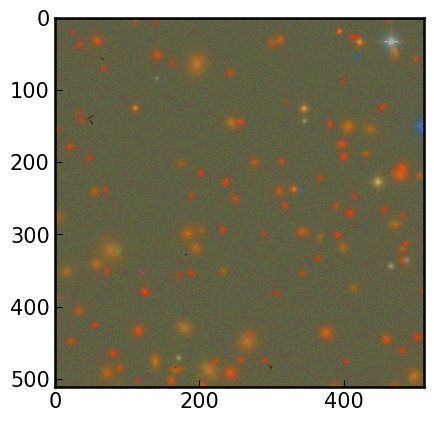

In [12]:
d=random.sample(dataset_dicts['test'], 1)[0]
#c = np.random.choice(scalings,1)[0]

#img = rescale_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.int16)
img = read_image(d["file_name"], normalize='lupton', stretch=5, Q=10, ceil_percentile=99.99,dtype=np.uint8)

plt.imshow(img)

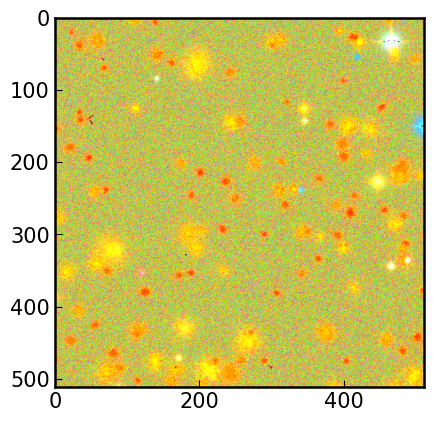

In [13]:
factor = 2 #gives original image

cenhancer = ImageEnhance.Contrast(Image.fromarray(img))

im_output = cenhancer.enhance(factor)
benhancer = ImageEnhance.Brightness(im_output)
im_output = benhancer.enhance(factor)
plt.imshow(im_output)

In [14]:
'''

means = np.zeros(3)
stds = np.zeros(3)

m0=m1=m2=0
s0=s1=s2=0

for d in dataset_dicts['train']:
    img = rescale_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.int16)
    m0+=img[:,:,0].mean()
    m1+=img[:,:,1].mean()
    m2+=img[:,:,2].mean()
    
    s0+=img[:,:,0].std()
    s1+=img[:,:,1].std()
    s2+=img[:,:,2].std()
    
means[0] = m0
means[1] = m1
means[2] = m2

stds[0] = s0
stds[1] = s1
stds[2] = s2
tl=len(dataset_dicts['train'])
print(means/tl)
print(stds/tl)

'''

'\n\nmeans = np.zeros(3)\nstds = np.zeros(3)\n\nm0=m1=m2=0\ns0=s1=s2=0\n\nfor d in dataset_dicts[\'train\']:\n    img = rescale_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.int16)\n    m0+=img[:,:,0].mean()\n    m1+=img[:,:,1].mean()\n    m2+=img[:,:,2].mean()\n    \n    s0+=img[:,:,0].std()\n    s1+=img[:,:,1].std()\n    s2+=img[:,:,2].std()\n    \nmeans[0] = m0\nmeans[1] = m1\nmeans[2] = m2\n\nstds[0] = s0\nstds[1] = s1\nstds[2] = s2\ntl=len(dataset_dicts[\'train\'])\nprint(means/tl)\nprint(stds/tl)\n\n'

### Augmented Data

Only plot the bounding boxes for clarity

### Testing Custom Augmentations

In [15]:
detectron2.__path__

['/home/g4merz/.local/lib/python3.9/site-packages/detectron2']

In [11]:
from astrodet.astrodet import CustomAug
#from detectron2.data.transforms.augmentation import KRandomAugmentationList
detectron_addons.KRandomAugmentationList

astrodet.detectron.KRandomAugmentationList

In [12]:

import imgaug.augmenters.flip as flip
import imgaug.augmenters.blur as blur


def hflip(image):
    return flip.fliplr(image)

#def gaussblur(image):
#    return blur.blur_gaussian_(image,sigma=np.random.random_sample()*4+2)

def gaussblur(image):
    aug = iaa.GaussianBlur(sigma=(0.0, np.random.random_sample()*4+2))
    return aug.augment_image(image)

def addelementwise16(image):
    aug = iaa.AddElementwise((-3276, 3276))
    return aug.augment_image(image)

def addelementwise8(image):
    aug = iaa.AddElementwise((-25, 25))
    return aug.augment_image(image)


def addelementwise(image):
    aug = iaa.AddElementwise((-image.max()*.1, image.max()*.1))
    return aug.augment_image(image)

In [13]:
scalings = np.array(['lupton','luptonHC','zscore'])
c = np.random.choice(scalings,1)
print(c)

for i in range(0,10):
    c = np.random.choice(scalings,1)
    print(c)

['lupton']
['zscore']
['luptonHC']
['zscore']
['lupton']
['luptonHC']
['zscore']
['luptonHC']
['luptonHC']
['zscore']
['zscore']


In [28]:
def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = read_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.uint8)
    #image = rescale_image(dataset_dict["file_name"], normalize='zscore', dtype=np.int16, ceil_percentile=99.995)
    
    #image = rescale_image(dataset_dict["file_name"], **read_image_args)
    '''
    augs = T.AugmentationList([
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.RandomFlip(prob=0.5,horizontal=False,vertical=True),
        T.Resize((512,512))
        
    ])
    '''
    
    augs = detectron_addons.KRandomAugmentationList([
        # my custom augs
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.RandomFlip(prob=0.5,horizontal=False,vertical=True),
        CustomAug(gaussblur,prob=1.0),
        CustomAug(addelementwise,prob=1.0)
        #CustomAug(white),
        ],
        k=-1,
        #cropaug=T.RandomCrop('relative',(0.5,0.5))
    )
    
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

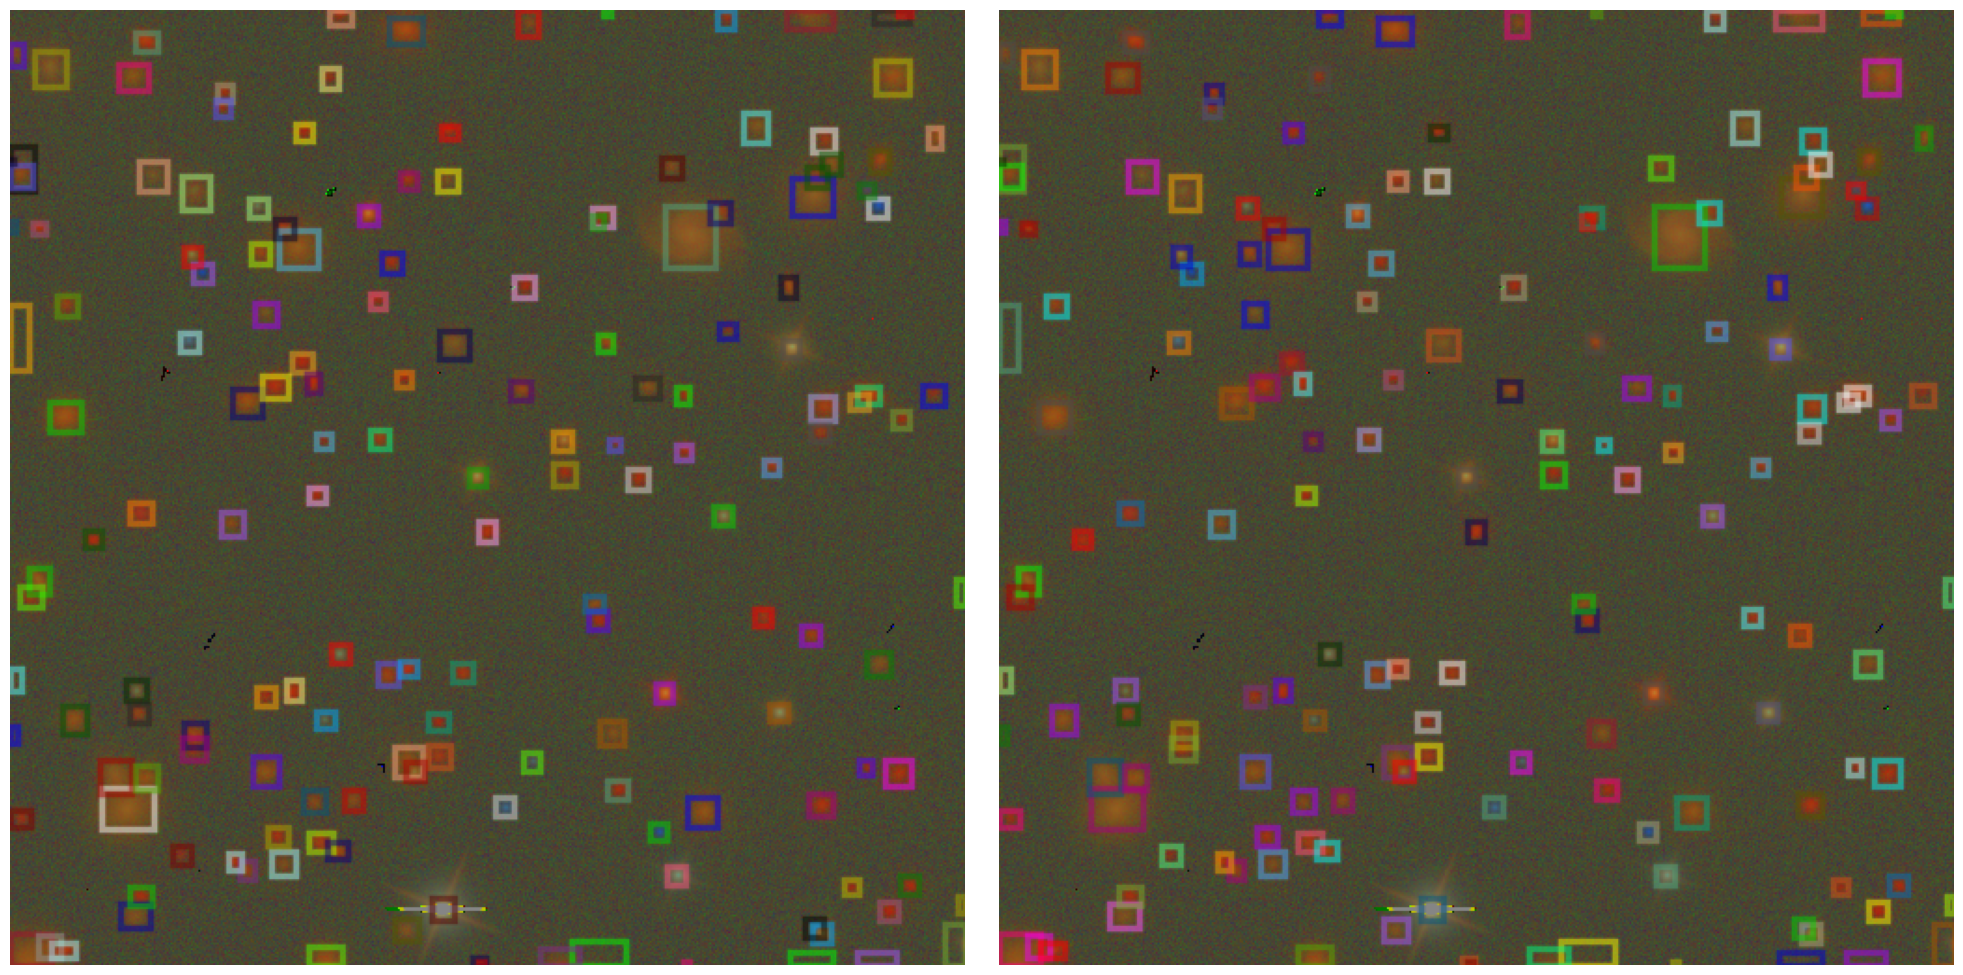

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))

#dictionary = iter(dataset_dicts['test'])
#d = next(dictionary)

d=random.sample(dataset_dicts['test'],1)[0]

astro_metadata = MetadataCatalog.get("astro_test")
img = read_image(d["file_name"], normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.uint8)
#img = rescale_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.9,dtype=np.int16)

visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a['bbox'] for a in d['annotations']])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis('off')

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astro_metadata, scale=1)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d['instances'].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

### Prepare For Training

In [24]:
import detectron2.utils.comm as comm
from detectron2.utils.events import EventStorage, get_event_storage
from detectron2.utils.logger import _log_api_usage
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, TensorboardXWriter
from typing import List, Mapping, Optional
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from detectron2.engine.hooks import LRScheduler
from detectron2.solver import build_lr_scheduler, build_optimizer
from fvcore.common.param_scheduler import ParamScheduler
from detectron2.utils.logger import log_every_n_seconds
import datetime
import logging

In [20]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # Get model structure
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 

In [13]:
#self.scheduler = self.build_lr_scheduler(cfg, optimizer)

In [ ]:
!nvidia-smi

In [15]:
# Training logic:

# To replicate 2019 methodology, need to 
# 1) run intially with backbone frozen (freeze_at=4) for 15 epochs
# 2) unfreeze and run for [25,35,50] epochs with lr decaying by 0.1x each time




In [19]:
cfg.DATASETS.TRAIN

'astro_test'

In [ ]:

# Step 1)

init_coco_weights = True # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_test") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'model_temp.pth')  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 4  # this is images per iteration. 1 epoch is len(images)/(ims_per_batch iterations*num_gpus)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []         # do not decay learning rate for retraining
cfg.SOLVER.MAX_ITER = 200     # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.PIXEL_MEAN = [-200,-200,-200]

cfg.MODEL.BACKBONE.FREEZE_AT = 4   # Initial re-training of the head layers (i.e. freeze the backbone)

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]
cfg.INPUT.MIN_SIZE_TRAIN = 512
cfg.INPUT.MAX_SIZE_TRAIN = 512

cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
# Type of gradient clipping, currently 2 values are supported:
# - "value": the absolute values of elements of each gradients are clipped
# - "norm": the norm of the gradient for each parameter is clipped thus
#   affecting all elements in the parameter
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
# Maximum absolute value used for clipping gradients
# Floating point number p for L-p norm to be used with the "norm"
# gradient clipping type; for L-inf, please specify .inf
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 5.0

cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0

cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
print(type(optimizer))

In [24]:
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


[01/11 12:38:05 d2.data.build]: Removed 0 images with no usable annotations. 250 images left.
[01/11 12:38:05 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    star    | 3356         |   galaxy   | 30750        |
|            |              |            |              |
|   total    | 34106        |            |              |
[01/11 12:38:05 d2.data.build]: Using training sampler TrainingSampler
[01/11 12:38:05 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/11 12:38:05 d2.data.common]: Serialized dataset takes 4.07 MiB


In [27]:
test_loader = data.build_detection_test_loader(cfg,cfg.DATASETS.TEST,mapper=test_mapper)

[01/11 12:40:23 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/11 12:40:23 d2.data.common]: Serialized dataset takes 4.07 MiB


In [29]:
#tl=len(dataset_dicts['test'])
tl=1000
e1=int(tl/cfg.SOLVER.IMS_PER_BATCH*15)
e2=int(tl/cfg.SOLVER.IMS_PER_BATCH*10)
e3=int(tl/cfg.SOLVER.IMS_PER_BATCH*20)
efinal=int(tl/cfg.SOLVER.IMS_PER_BATCH*35)

print(e1/2,e2/2,e3/2,efinal/2)

1875.0 1250.0 2500.0 4375.0


In [30]:
#dataloader = build_detection_train_loader(cfg, mapper=train_mapper)

In [31]:
# Hack if you get SSL certificate error 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [55]:
detectron2.__path__

['/home/g4merz/.local/lib/python3.9/site-packages/detectron2']

In [ ]:
print(trainer.scheduler.get_lr())
print(trainer.scheduler.state_dict())
#print(trainer.scheduler.last_epoch,trainer.scheduler._max_iter)
print(trainer.scheduler._multiplier(10 / trainer.scheduler._max_iter))

In [ ]:
valperiod=50
saveHook = toolkit.SaveHook()
schedulerHook = toolkit.CustomLRScheduler(optimizer=optimizer)
lossHook = toolkit.LossEvalHook(valperiod, model, test_loader)

saveHook.set_output_name("test_zscore_notebook")
hookList = [lossHook,schedulerHook,saveHook]

#trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer = toolkit.NewAstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)

In [ ]:
t0 = time.time()
period=10
trainer.set_period(period) # print loss every n iterations
trainer.train(0,150)
print('time ', time.time()-t0)

In [70]:
# Step 2)

cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze all backbone layers  
cfg.SOLVER.BASE_LR = 0.0001   
#cfg.SOLVER.STEPS = [e2,e3]        # decay learning rate
cfg.SOLVER.STEPS = [500,1000]        # decay learning rate

cfg.SOLVER.MAX_ITER = efinal          # for DefaultTrainer
cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'test_zscore_notebook.pth')  # Initialize from a local weights

model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


[01/03 13:08:56 d2.data.build]: Removed 0 images with no usable annotations. 250 images left.
[01/03 13:08:56 d2.data.build]: Using training sampler TrainingSampler
[01/03 13:08:56 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[01/03 13:08:57 d2.data.common]: Serialized dataset takes 4.07 MiB


In [ ]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(20) # print loss every n iterations
trainer.train(0, 400)

In [39]:
output_dir = '/home/shared/hsc/decam/models/'
output_name='baseline_R101'
print(os.path.join(output_dir, output_name+'.pth'))


/home/shared/hsc/decam/models/baseline_R101.pth


### Plot The Loss

In [397]:
# Look at training curves in tensorboard:
#%load_ext tensorboard
#%tensorboard --logdir output --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1389625), started 0:05:55 ago. (Use '!kill 1389625' to kill it.)

In [26]:
losses = np.load('/home/shared/hsc/decam/models/int16/R101fpn_sat99.99_zscore_losses.npy')
val_losses = np.load('/home/shared/hsc/decam/models/int16/R101fpn_sat99.99_zscore_val_losses.npy')

vperiod = np.ceil(len(losses)/len(val_losses))
iters = np.arange(len(val_losses))*vperiod
print(vperiod)

250.0


In [27]:
len(losses)


12500

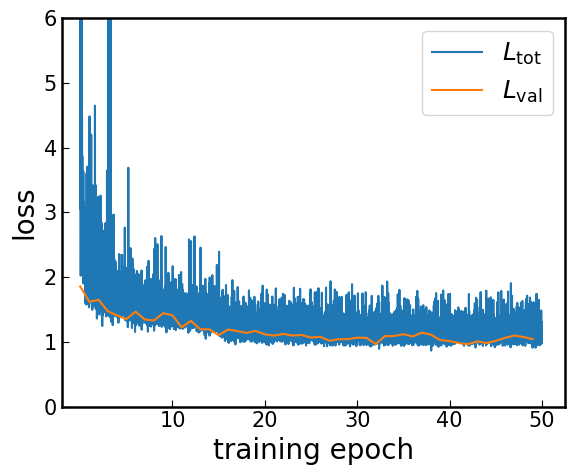

In [28]:
epochs = np.array([1000/4*10,1000/4*20,1000/4*30,1000/4*40,1000/4*50])
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xticks(epochs)
ax.set_xticklabels(['10','20','30','40','50'])
ax.set_xlim(-500,len(losses)*1.05)
ax.set_ylim(0,6)

ax.plot(losses, label=r'$L_{\rm{tot}}$')
ax.plot(iters,val_losses, label=r'$L_{\rm{val}}$')

ax.legend(loc='upper right')
ax.set_xlabel('training epoch', fontsize=20)
ax.set_ylabel('loss', fontsize=20)
fig.tight_layout()

### Inference

In [29]:
import importlib
importlib.reload(toolkit)
from astrodet import astrodet as toolkit
toolkit.AstroPredictor
output_dir = '/home/shared/hsc/decam/models/int8/'


In [25]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_test") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 4  # this is images per iteration. 1 epoch is len(images)/(ims_per_batch iterations*num_gpus)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []         # do not decay learning rate for retraining
cfg.SOLVER.MAX_ITER = 100     # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.PIXEL_MEAN= [-200,-200,-200]
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 512

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "oldbaseline.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
#predictor = DefaultPredictor(cfg)
predictor = toolkit.AstroPredictor(cfg)

[01/19 12:56:46 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

total instances: 137
detected instances: 114

total instances: 135
detected instances: 98

total instances: 169
detected instances: 127



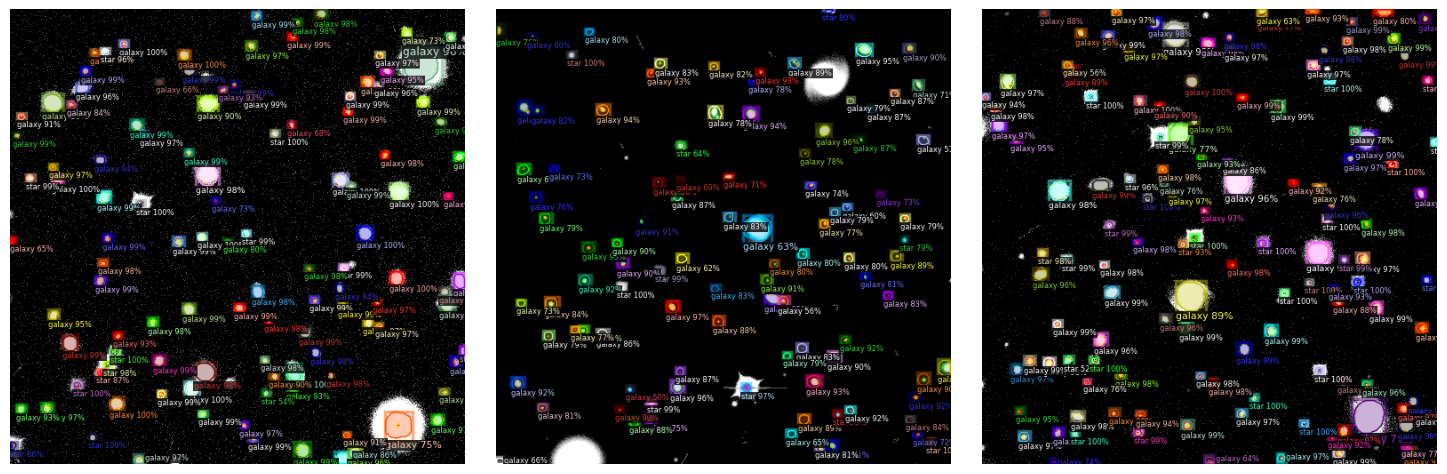

In [93]:
from detectron2.utils.visualizer import ColorMode

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    #img = read_image(d["file_name"], normalize="zscore", stretch=5, Q=1, ceil_percentile=99.99, dtype=np.int16)
    img = rescale_image(d["file_name"], normalize='zscore', dtype=np.int16, ceil_percentile=99.995)

    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    
    print('total instances:', len(d['annotations']))
    print('detected instances:', len(outputs['instances'].pred_boxes))
    print('')
    
    v = Visualizer(img,
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [22]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    #image = read_image(dataset_dict["file_name"], normalize="zscore", stretch=5, Q=1, ceil_percentile=99.99, dtype=np.uint8)
    image = rescale_image(dataset_dict["file_name"], normalize='zscore', dtype=np.int16, ceil_percentile=99.995)

    augs = T.AugmentationList([
        #T.RandomRotation([-90, 90, 180], sample_style='choice'),
        #T.RandomFlip(prob=0.5),
        #T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos
    }

In [100]:
len(dataset_dicts['test'])

50

In [53]:
# All of the astro_train_coco... stuff gets generated here...
# only keep last_checkpoint and model_temp.pth files really.

print(MetadataCatalog.get("astro_" + d))


Metadata(name='astro_val', thing_classes=['star', 'galaxy'], things_colors=['blue', 'gray'])


In [29]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader, get_detection_dataset_dicts

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_test", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

# First run with train_mapper to generate .json files consistent with training format
# Then run with test_mapper to get AP scores (doesn't work with augmentation mapper)
#train_loader = build_detection_test_loader(cfg, dataset_dicts['train'], mapper=train_mapper)
#test_loader = build_detection_test_loader(cfg, dataset_dicts['val'], mapper=test_mapper)

train_loader = build_detection_test_loader('astro_train', mapper=train_mapper)
test_loader = build_detection_test_loader(dataset_dicts['test'], mapper=test_mapper)

[01/19 12:58:31 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[01/19 12:58:31 d2.data.common]: Serialized dataset takes 0.83 MiB


In [30]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

[01/19 12:58:34 d2.evaluation.evaluator]: Start inference on 50 batches


/home/g4merz/.conda/envs/astrodetnv/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/19 12:58:38 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.0674 s/iter. Inference: 0.0533 s/iter. Eval: 0.0642 s/iter. Total: 0.1849 s/iter. ETA=0:00:07
[01/19 12:58:43 d2.evaluation.evaluator]: Inference done 34/50. Dataloading: 0.0971 s/iter. Inference: 0.0538 s/iter. Eval: 0.0657 s/iter. Total: 0.2166 s/iter. ETA=0:00:03
[01/19 12:58:46 d2.evaluation.evaluator]: Total inference time: 0:00:09.375394 (0.208342 s / iter per device, on 1 devices)
[01/19 12:58:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.053773 s / iter per device, on 1 devices)
[01/19 12:58:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/19 12:58:46 d2.evaluation.coco_evaluation]: Saving results to /home/shared/hsc/decam/models/int16/coco_instances_results.json
[01/19 12:58:46 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
()
_evaluate_predictions_on_coco
Loading and preparing results...
DONE (t=0.00s)
crea

In [97]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

[01/17 14:34:41 d2.evaluation.evaluator]: Start inference on 250 batches
[01/17 14:34:43 d2.evaluation.evaluator]: Inference done 11/250. Dataloading: 0.0659 s/iter. Inference: 0.0534 s/iter. Eval: 0.0633 s/iter. Total: 0.1826 s/iter. ETA=0:00:43
[01/17 14:34:48 d2.evaluation.evaluator]: Inference done 35/250. Dataloading: 0.0890 s/iter. Inference: 0.0539 s/iter. Eval: 0.0647 s/iter. Total: 0.2078 s/iter. ETA=0:00:44
[01/17 14:34:53 d2.evaluation.evaluator]: Inference done 61/250. Dataloading: 0.0830 s/iter. Inference: 0.0540 s/iter. Eval: 0.0650 s/iter. Total: 0.2021 s/iter. ETA=0:00:38
[01/17 14:34:58 d2.evaluation.evaluator]: Inference done 87/250. Dataloading: 0.0809 s/iter. Inference: 0.0539 s/iter. Eval: 0.0645 s/iter. Total: 0.1993 s/iter. ETA=0:00:32
[01/17 14:35:03 d2.evaluation.evaluator]: Inference done 113/250. Dataloading: 0.0796 s/iter. Inference: 0.0538 s/iter. Eval: 0.0641 s/iter. Total: 0.1977 s/iter. ETA=0:00:27
[01/17 14:35:08 d2.evaluation.evaluator]: Inference done

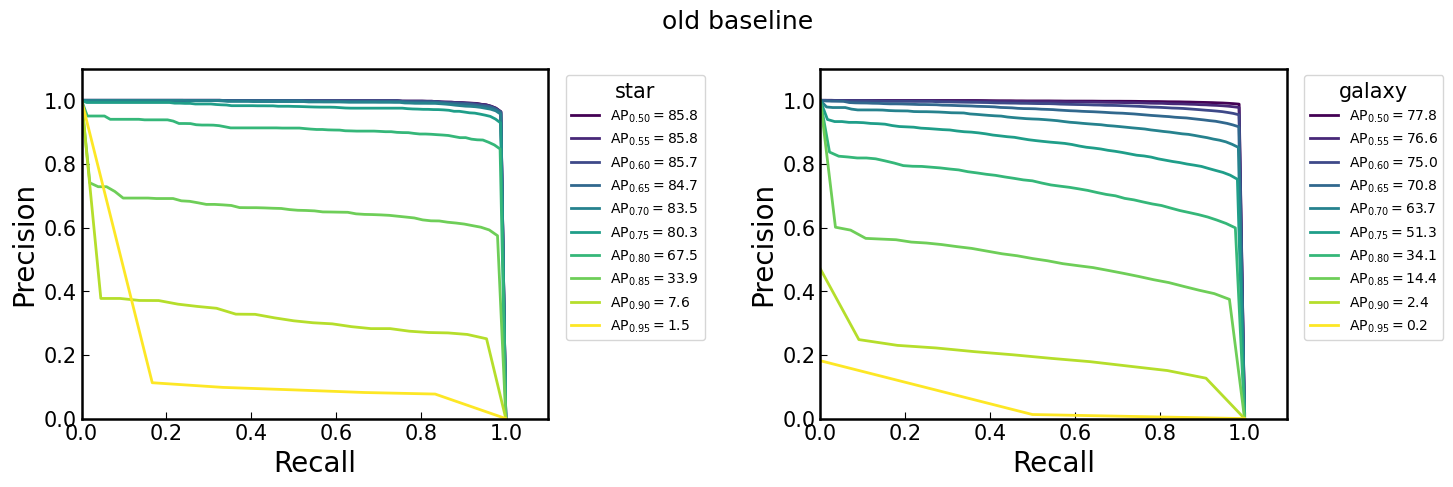

In [98]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']

results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
plt.suptitle('old baseline')

fig.tight_layout()

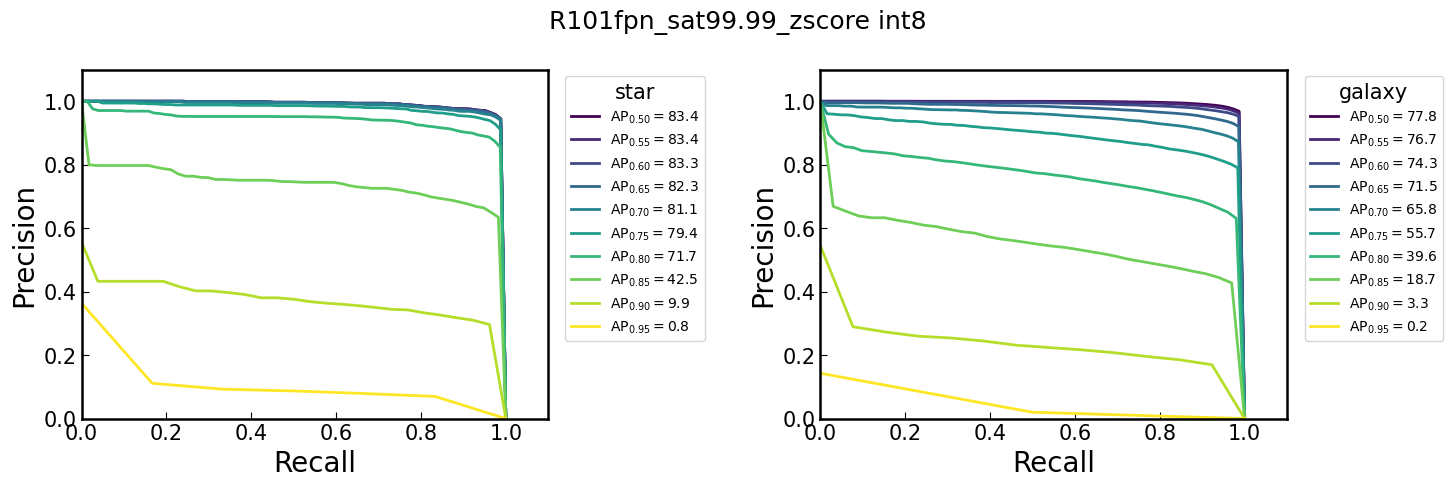

In [88]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']

results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
plt.suptitle('R101fpn_sat99.99_zscore int8')
        
fig.tight_layout()

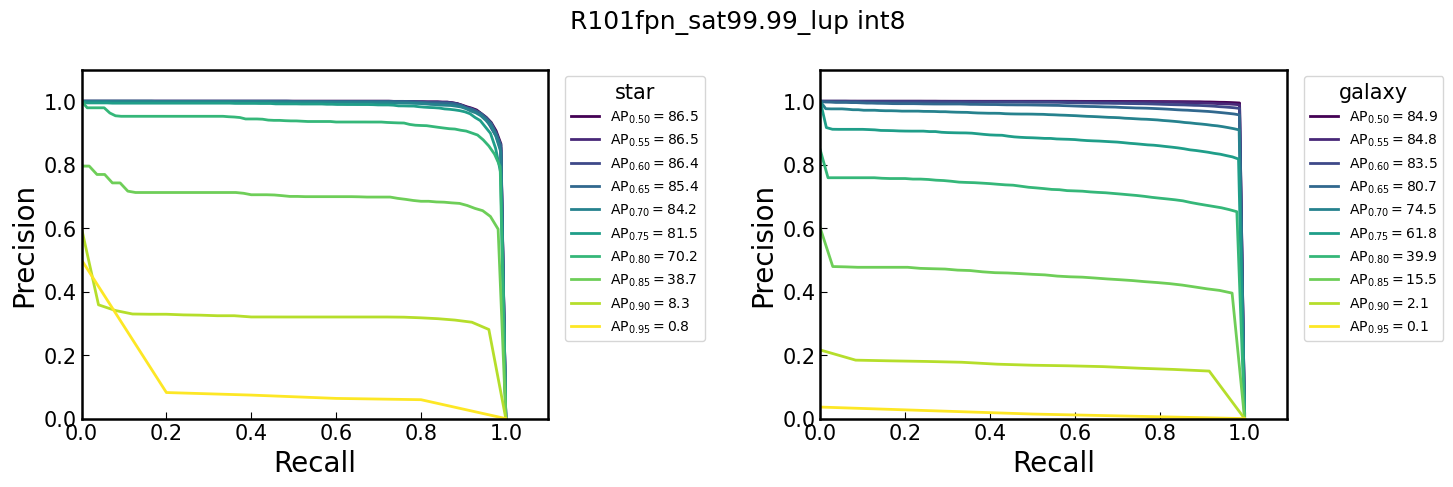

In [75]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']

results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
plt.suptitle('R101fpn_sat99.99_lup int8')
fig.tight_layout()
